## XVIII LEGISLATURA

In [2]:
import pandas as pd
import logging
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
import time
import pprint
import pickle
import random
import numpy as np
from sklearn.metrics import accuracy_score,precision_recall_curve, average_precision_score, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime
import re
import json
import pandas
import operator
from functools import reduce
import editdistance
import copy
import regex
from nltk.tokenize import RegexpTokenizer
from string import punctuation
from nltk.corpus import stopwords

In [3]:
dataset_file = 'parliament/XVIII_legislature_italian_republic.json'

with open(dataset_file, 'r') as infile:
    dataset = json.load(infile)

In [4]:
len(dataset)

318

## Controlli e test

In [ ]:
print(dataset[0])

#è scritto a computer, no errori ortografici

In [260]:
find = []
intro = ['Atti ', 'Alti ', 'A t t i ', 'Att i ', 'Alt i ', 'Allt ', 'At t i ', 'd t t i ']

for d in dataset:
    d['text'] = d['text'].replace('\n', ' ')
    year = d['date'].split('-')[0][1:4]
    
    resulttot = []
    for i in intro:
        result = re.findall(i+'(.+?)'+year, d['text'])
        result = [i+elem+year for elem in result]
        
        resulttot.append(result)

    resulttot = reduce(operator.concat, resulttot)

    find.append(resulttot)

In [261]:
find = reduce(operator.concat, find)

In [ ]:
cont = 0
lenght = []
for l in find:
    if len(l)>200:
        pprint(l)
        cont = cont+1
    if len(l)<4000:
        lenght.append(len(l))

In [264]:
pprint(np.mean(lenght))

112.91381569369632


{'whiskers': [<matplotlib.lines.Line2D at 0x1a8eeeabd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a8eee5750>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a8eef6750>],
 'medians': [<matplotlib.lines.Line2D at 0x1a8eef6c10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a8eef2b90>],
 'means': []}

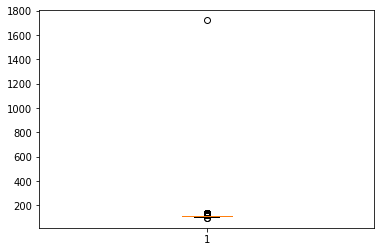

In [265]:
plt.boxplot(lenght)

In [267]:
#voglio vedere quante volte riesco a trovare la dicitura che mi indica l'inizio della seduta

result = []  
for d in dataset:
        res = regex.search('(La)\s+(seduta){e<3}\s+(comincia){e<4}',d['text'])
        if res != None:
            result.append(res.group())

In [271]:
#verifico quanto spesso trovo la fine della seduta e splitto in modo che isolo le cose che vengono dopo 

result = [] 
for d in dataset:
    if 'seduta' in d.keys():
        res = regex.search('(La)\s+(seduta){e<2}\s+(termina){e<3}',d['seduta'])
        if res != None:
            result.append(res.group())

In [275]:
#cerco quante volte riesco a trovare l'inizio delle interrogazioni
#non vi sono interrogazioni

notresult = []
result = []
cont = 0

for d in dataset_pulito:
    if 'seduta' in d.keys():
        res = regex.search('(Si){e<2}\s+(dia){e<2}\s+(lettura){e<3}\s+(delle){e<2}\s+(interrogazioni){e<6}',d['seduta'])
        if res != None:
            result.append(res.group())
        else: notresult.append(cont)
    cont = cont + 1

In [276]:
pprint(result) #non vi sono interrogazioni (magari già eliminate con la seduta termina)

[]


In [277]:
notresult = []
result = []
cont = 0

for d in dataset_pulito:
    if 'seduta' in d.keys():
        res = regex.search('(VOTAZIONI){e<3}\s+(QUALIFICATE){e<3}\s+(EFFETTUATE){e<4}\s+(MEDIANTE){e<3}\s+(PROCEDIMENTO){e<4}\s+(ELETTRONICO){e<4}',d['seduta'])
        if res != None:
            result.append(res.group())
        else: notresult.append(cont)
    cont = cont + 1

In [278]:
pprint(result) #non vi sono votazioni (probabilmente eliminta con la seduta termina)

[]


In [279]:
#voglio vedere quante volte riesco a trovare la dicitura che indica il presidente

notresult = []
result = []
cont = 0

for d in dataset_pulito:
    if 'index' in d.keys():
        res = regex.search('(PRESIDENZA)\s+(DEL){e<3}\s+(PRESIDENTE){e<4}',d['index']) 
        
        if res != []:
            result.append(res)

        else:    
            res = regex.search('(PRESIDENZA){e<3}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',d['index']) 

            if res != []:
                result.append(res)
            else:
                notresult.append(cont)
    cont = cont +1

In [280]:
pprint(len(result)) #sempre - Legis XVIII

318


## Pulizia del testo

### Prima pulizia
Rimonzione \n e introduzione di ogni pagina

In [491]:
dataset_pulito = []
find = []
cont = 0
i = 'Atti'

for d in dataset:
    d['text'] = d['text'].replace('\n', ' ')
    year = d['date'].split('-')[0][0:4] 
    
    resulttot = []
    
    result = re.findall(i+'(.+?)'+year, d['text'])
  
    result = [i+elem+year for elem in result]
    result = [elem for elem in result if len(elem)< 160]
        
    resulttot.append(result)

    resulttot = reduce(operator.concat, resulttot)
    #pprint(resulttot)
    find.append(resulttot)
    
    for l in resulttot:
        d['text'] = d['text'].replace(l, '')
        
    dataset_pulito.append(d)

    cont = cont +1

### Split inizio e fine seduta

In [492]:
#Splitto sull'inizio seduta

for d in dataset_pulito:
    res = regex.search('(La){e<2}\s+(seduta){e<3}\s+(comincia){e<4}',d['text'])
    if res !=None:
        split = d['text'].split(res.group(),1)
        d.pop('text', None)
        d['index'],d['seduta'] = split[0], split[1]

In [493]:
#Lo trovo praticamente ovunque tranne in 4 - Legis XVII
#Lo trovo sempre - legis XVIII

cont = 0
for d in dataset_pulito:
    if 'index' not in d.keys():
        cont+=1
        
pprint(cont)

0


In [494]:
#Splitto la fine della seduta

for d in dataset_pulito:
    if 'seduta' in d.keys():
        res = regex.search('(La){e<2}\s+(seduta){e<2}\s+(termina){e<3}',d['seduta'])
        if res !=None:
            split = d['seduta'].split(res.group(),1)
            d['seduta'],d['end'] = split[0], split[1]

In [503]:
for d in dataset_pulito:
    if 'seduta' in d.keys():
         d['seduta'] = d['seduta'].replace('  — N. ', ' ')

### Controllo interrogazioni e votazioni

### Presidenza

In [468]:
pattern = '\w+|\$[\d\.]+|\S+'
tokenizer = RegexpTokenizer(pattern)

In [469]:
def find_presidente(data):
        pres = {}
        res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(PRESIDENTE){e<4}',data) 
        
        if res != None:
            pres['presidente'] = data.split(res.group(),1)[1]
            pres['presidente'] = tokenizer.tokenize(pres['presidente'])
            pres['presidente'] = [x for x in pres['presidente'] if x not in punctuation]
            if len(pres['presidente'])<5:
                flag = 1 #a volte trova quello in fondo, non voglio fare return
            else:    
                return pres
        
        if regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',data) != None: 
            res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',data)
            pres['presidente'] = data.split(res.group(),1)[1]
            pres['presidente'] = tokenizer.tokenize(pres['presidente'])
            pres['presidente'] = [x for x in pres['presidente'] if x not in punctuation]
            return pres
        
        else: return False
        
        #quando ho indi vuol dire che ho doppio presidente

In [504]:
#Vado a salvare il campo presidente

presidenza2 = []
result = []
cont = 0

for d in dataset_pulito:
    if 'index' in d.keys():
        check = False
        pres = find_presidente(d['index'])
        
        if regex.search('(PROVVISORIO){e<4}',pres['presidente'][0]) != None :
                check = True
                
        if check == True:
            if pres['presidente'][3].isupper() and len(pres['presidente'][3])>1 and pres['presidente'][3]!= 'INDI':
               pres['presidente'] = pres['presidente'][1]+" "+pres['presidente'][2]+" "+pres['presidente'][3]
               
            else:  
                pres['presidente'] = pres['presidente'][1]+" "+pres['presidente'][2]
               
        else:
            if pres['presidente'][2].isupper() and len(pres['presidente'][2])>1 and pres['presidente'][2]!= 'INDI':
                pres['presidente'] = pres['presidente'][0]+" "+pres['presidente'][1]+" "+pres['presidente'][2]
            else:   pres['presidente'] = pres['presidente'][0]+" "+pres['presidente'][1]
        

        d['presidente'] = [pres['presidente']]  #salvo tutto come presidente, non tengo la distinzione
        
        
    else:
        pres = {}
        pres['presidente'] = []
   
    pres['doc'] = cont

    presidenza2.append(pres)
    cont = cont+1



In [506]:
pickle.dump( dataset_pulito, open("Dataset_pulito.nosync/dataset_pulito_XVIII_prima.p", "wb" ) )
#risalvare quesllo della XVII legis

In [ ]:
dataset_pulito = pickle.load()

In [ ]:
for d in dataset_pulito:
    if 'presidente' in d.keys():
        pprint(d['presidente'])

In [ ]:
#prova per verificare come cambiano i presidenti 

cont = 0 
result = []

for d in dataset_pulito:
    if 'seduta' in d.keys():
        res_prov = {}
        res_prov['doc']=cont
        res_prov['pres'] = []
        res = regex.findall('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(PRESIDENTE){e<4}',d['seduta'])
        print(cont)
        if res!=[]:
            for r in res:
                r = ' '.join(r)
                pres = d['seduta'].split(r)[1]
                pres = tokenizer.tokenize(pres)
                pres = pres[0:2]
                res_prov['pres'].append(pres)
                
        res = regex.findall('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',d['seduta'])
        if res!=[]:
            for r in res:
                r = ' '.join(r)
                pres = d['seduta'].split(r)[1]
                pres = tokenizer.tokenize(pres)
                pres = pres[0:2]
                res_prov['pres'].append(pres)
        
        if res_prov['pres']!= []:
            result.append(res_prov)
                
    cont = cont+1
    

In [513]:
dataset_pulito = pickle.load(open("Dataset_pulito.nosync/dataset_pulito_XVIII_prima.p", "rb" ) )

In [ ]:
cont = 0
pres = {}

for d in dataset_pulito: 
    if 'seduta' in d.keys() and 'presidente' in d.keys():
        d['seduta'] = [d['seduta']]
        i = 0
        res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(PRESIDENTE){e<5}',d['seduta'][0])

        if res == None:
            res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',d['seduta'][0])


        while res != None: #continuo a splittare finchè trovo che c'è un nuovo presidente
            check = False
            split = d['seduta'][i].split(res.group(),1)
            d['seduta'].pop(i)
            d['seduta'].append(split[0])
            d['seduta'].append(split[1])

            pres['presidente'] = tokenizer.tokenize(split[1])
            pres['presidente'] = [x for x in pres['presidente'] if x not in punctuation]

            if regex.search('(PROVVISORIO){e<4}',pres['presidente'][0]) != None :
                check = True
                
            if check == True:
                if pres['presidente'][3].isupper() and len(pres['presidente'][3])>1 and pres['presidente'][3] != 'PRESIDENTE':
                    pres['presidente'] = pres['presidente'][1]+" "+pres['presidente'][2]+" "+pres['presidente'][3]
                else:   pres['presidente'] = pres['presidente'][1]+" "+pres['presidente'][2]

            else:
                 if pres['presidente'][2].isupper() and len(pres['presidente'][2])>1 and pres['presidente'][2] != 'PRESIDENTE':
                    pres['presidente'] = pres['presidente'][0]+" "+pres['presidente'][1]+" "+pres['presidente'][2]
                 else:   pres['presidente'] = pres['presidente'][0]+" "+pres['presidente'][1]

            d['presidente'].append(pres['presidente'])


            i = i+1
            res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(PRESIDENTE){e<5}',d['seduta'][i])
            #<5 così se ho vicepresidente prima lo trovo cmq
            
            if res == None:
                res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',d['seduta'][i])
          
    pprint(cont)       
    cont = cont+1

In [ ]:
for d in dataset_pulito:
    pprint(d['presidente'])

In [516]:
len_p = []
for d in dataset_pulito:
    if 'presidente' in d.keys():
        for p in d['presidente']:
             len_p.append(len(d['presidente']))

In [517]:
pprint(np.max(len_p))
pprint(np.mean(len_p))
pprint(np.median(len_p))

6
2.708141321044547
3.0


In [541]:
for d in dataset_pulito:
    if 'presidente' in d.keys():
        cont = 0
        for p in d['presidente']:
            pr = p.split(' ')
            if len(pr) > 2 and pr[2] == 'PRESIDENTE':
                print(d['presidente'][cont])
                d['presidente'][cont] = pr[0]+" "+pr[1]
                print(d['presidente'][cont])
            cont = cont+1

In [ ]:
cont = 0
for d in dataset:
    if 'seduta' in dataset_pulito[cont].keys():
        l = len(d['text'])
        l2 = len(dataset_pulito[cont]['index'])+len('la seduta comincia')
        for s in dataset_pulito[cont]['seduta']:
            l2 = l2+len(s)+len('PRESIDENZA DEL PRESIDENTE')
        if 'end' in dataset_pulito[cont].keys():
            l2 = l2+len(dataset_pulito[cont]['end'])+len('LA SEDUTA TERMINA')
    pprint(str(cont)+" "+str(l)+" "+str(l2))
    cont = cont+1

In [542]:
pickle.dump( dataset_pulito, open("Dataset_pulito.nosync/dataset_pulito_XVIII.p", "wb" ) )

In [218]:
dataset_pulito = pickle.load(open("Dataset_pulito.nosync/dataset_pulito_XVII.p", "rb" ) )

## Estrazione dei Discorsi

### Estrazione nomi dei politici

In [553]:
politici = {}

for d in dataset_pulito:
    if 'presidente' in d.keys():
        for p in d['presidente']:
            if p not in politici.keys():
                politici[p] = 1

In [658]:
presidenti = {}

for d in dataset_pulito:
    if 'presidente' in d.keys():
        for p in d['presidente']:
            if p not in presidenti.keys():
                presidenti[p] = 1

In [659]:
pprint(presidenti)

{'180 MARIA ROSARIA': 1,
 '20 ROBERTO FICO': 1,
 '54 MARIA ROSARIA': 1,
 '94 ETTORE ROSATO': 1,
 'ETTORE ROSATO': 1,
 'ETTORE ROSATO (ORE': 1,
 'FABIO RAMPELLI': 1,
 'FABIO RAMPELLI (ORE': 1,
 'LORENZO FONTANA': 1,
 'MARIA EDERA SPADONI': 1,
 'MARIA ROSARIA CARFAGNA': 1,
 'ROBERTO FICO': 1,
 'ROBERTO GIACHETTI': 1}


In [ ]:
pprint(politici) #quelli con gli errori si sistemano poi con le regex

In [555]:
#Prima cerco di estrarre i nomi dei leader e li salvo

cont = 0
flag = 0

for data in dataset_pulito:
    if 'seduta' in data.keys():
        for k in range(0,len(data['seduta'])):
            presidente = data['presidente'][k]
            
            text = data['seduta'][k]
            text_token = tokenizer.tokenize(text)
            text_token = [x for x in text_token if x not in punctuation]

            for i in range(0,len(text_token)):

                    word = text_token[i]
                    politico = re.search(r"[A-Z]{4,}", word)

                    if politico != None and i+2<len(text_token):
                        if editdistance.eval(politico.group(), 'PRESIDENTE')<4:
                            pol = presidente
                            politici[pol] = politici[pol]+1
                        
                        else:
                            if flag == 0: 
                                flag = 0
                                if text_token[i+1].isupper() and len(text_token[i+1])>1 and text_token[i+1][0]!='(' : #ignoro cose tipo XIII legisl

                                    if text_token[i+2].isupper() and len(text_token[i+2])>2 and text_token[i+2][0]!='(':
                                        pol = word+" "+text_token[i+1]+" "+text_token[i+2]

                                        if pol not in politici.keys():
                                            politici[pol] = 1
                                        else: politici[pol] = politici[pol]+1
                                        flag = 2


                                    else:
                                        pol = word+" "+text_token[i+1]
                                        if pol not in politici.keys():
                                            politici[pol] = 1
                                        else: politici[pol] = politici[pol]+1
                                        flag = 1

                            else: flag = flag -1

            cont = cont +1

In [579]:
pprint(len(politici))

820


In [564]:
politici_max = [] #tengo solamente quelli con almeno 5 occorrenze

for k in politici.keys(): #no ho tanti alzo il numero delle occorrenze
    if politici[k] > 4:
        politici_max.append([k, politici[k]]) 

In [565]:
pprint(len(politici_max))

552


In [566]:
politici_max_name = [elem[0] for elem in politici_max]

In [585]:
#li aggrego in base alle somiglianze nel nome

politici_definitivi = []
cont = 1

for p in politici_max:
    for i in range(cont, len(politici_max)):
        if len(p[0]) <=  10 and editdistance.eval(p[0],politici_max[i][0])<2:
            p[1] = p[1] + politici_max[i][1]
            politici_max[i][1] = 0
            pprint(p[0]+" "+politici_max[i][0])
            
        if len(p[0]) > 10 and editdistance.eval(p[0],politici_max[i][0])<4: #abbasso il numero degli errori in quanto capita raramente
            p[1] = p[1] + politici_max[i][1]
            politici_max[i][1] = 0
            pprint(p[0]+" "+politici_max[i][0])
            
    cont = cont +1

'ROBERTO FICO 20 ROBERTO FICO'
'ETTORE ROSATO 94 ETTORE ROSATO'
'54 MARIA ROSARIA 180 MARIA ROSARIA'
'SEDUTA DI VENERDÌ SEDUTA DI LUNEDÌ'
'FRANCESCO SCOMA FRANCESCO SAPIA'
'GIANLUCA VACCA GIANLUCA VINCI'


In [ ]:
sorted(politici_max)

In [587]:
#elimino quelli che sono stati aggregati
politici_max_agg = [elem for elem in politici_max if elem[1]>0]

In [588]:
pprint(len(politici_max_agg))

546


In [589]:
politici_max_def = [elem for elem in politici_max if elem[1]>50]

In [590]:
pprint(len(politici_max_def))

#170 politici hanno almeno 100 discorso, vanno cmq ripuliti

110


In [ ]:
pprint(sorted(politici_max_def))

In [594]:
politici_max_def_name = [elem[0] for elem in politici_max_def] #politici che considero rilevanti

In [595]:
len(politici_max_name) #considero questi politici, quindi mi farebbero interrompere il discorso

552

In [597]:
politici_max_name.remove('XVIII LEGISLATURA')
politici_max_name.remove('SEDUTA DI VENERDÌ')
politici_max_name.remove('SEDUTA DI MARTEDÌ')

In [599]:
politici_max_def_name.remove('XVIII LEGISLATURA')

### Estrazione e salvataggio dei discorsi

In [600]:
def check_politico(pol):
        
    for cog in politici_max_def_name:
            res = editdistance.eval(cog,pol)
            
            if len(pol)  <= 10 and res<2:
                return True, cog
                
            if len(pol) > 10 and res<4:
                return True, cog
    
    return False, None

In [601]:
discorsi = {}

for cog in politici_max_def_name:
    discorsi[cog] = []

In [ ]:
#Salvo i discorsi

cont = 0
flag = 0
d = {}


for data in dataset_pulito:
    if 'seduta' in data.keys():
         for k in range(0,len(data['seduta'])):
            presidente = data['presidente'][k]
            
            text = data['seduta'][k]
            text_token = tokenizer.tokenize(text)
            text_token = [x for x in text_token if x not in punctuation]
            i = 0
            flag = 0
            d = {}

            for word in text_token:

                    politico = re.search(r"[A-Z]{4,}", word)

                    if politico != None and i+2<len(text_token):
                        
                        if editdistance.eval(politico.group(), 'PRESIDENTE')<4:
                            pprint(politico.group())
                            
                            if d!={} and len(d['discorso'])>2:
                                discorsi[d['politico']].append(d['discorso'])
                                pprint(str(cont)+' '+d['politico'])
                            
                                
                            flag = 0
                            d = {}
                            
                            pres, cog_pres = check_politico(presidente) #controllo se il presidente mi interessa
                            
                            if pres == True:
                                d['politico'] = cog_pres
                                d['discorso'] = []
                                flag = 1
                        
                        else:
                            pol = politico.group()+" "+text_token[i+1]
      
                            pol2 =  politico.group()+" "+text_token[i+1]+" "+text_token[i+2]
             
                            
                            if (pol in politici_max_name) or (pol2 in politici_max_name): #se non è in questa lista non lo considero un politico 
                                    if d!={} and len(d['discorso'])>2: #salvo perchè significa che inizia un altro discorso
                                        discorsi[d['politico']].append(d['discorso'])
                                        pprint(str(cont)+' '+d['politico'])
                                        
                                    
                                    flag = 0
                                    d = {}

                                    if text_token[i+2].isupper() and len(text_token[i+2])>2 and text_token[i+2][0]!='(': 
                                        check, cog = check_politico(pol2)
                                        if check == True:
                                            d['politico'] = cog
                                            d['discorso'] = []
                                            text_token.pop(i+1)
                                            text_token.pop(i+1)
                                            flag = 1

                                    else:
                                        check, cog = check_politico(pol)
                                        if check == True:
                                            flag = 1
                                            d['politico'] = cog
                                            d['discorso'] = []
                                            text_token.pop(i+1)

                            elif flag == 1: #vuol dire che è una parola in maiuscolo ma non è un politico
                                d['discorso'].append(word)
                         
                    elif flag ==1:
                        d['discorso'].append(word)
                    i = i +1
                    
            if d != {} and len(d['discorso'])>2: 
                discorsi[d['politico']].append(d['discorso'])
                pprint(str(cont)+' '+d['politico'])
               
    cont = cont +1

In [ ]:
for k in sorted(discorsi.keys()):
    print(k+" "+str(len(discorsi[k])))

In [ ]:
for d in discorsi['54 MARIA ROSARIA']:
    discorsi['MARIA ROSARIA CARFAGNA'].append(d)

discorsi.pop('54 MARIA ROSARIA')

In [650]:
#Salvo un file per ciascun politico con i suoi discorso

for cog in discorsi.keys():
    pickle.dump( discorsi[cog], open( 'Discorsi-XVIII-legis/'+cog+".p", "wb" ) )
    
    #arrivata qua, funziona!! salvato tutto 

In [651]:
pickle.dump( list(discorsi.keys()), open( 'Discorsi-XVIII-legis/cognomi_discorsi.p', "wb" ) )
#Salvato

In [661]:
lb = pickle.load( open( "Discorsi-XVIII-legis/cognomi_discorsi.p", "rb" ) )

In [664]:
leng = []
for k in discorsi.keys():
    leng.append(len(discorsi[k]))

In [665]:
pprint(len(leng))

108


In [666]:
np.mean(leng)

300.3425925925926

In [653]:
pprint(len(discorsi.keys()))

108


### punto della situazione

#### Cose fatte:
1. Ripulito il testo dall'intestazione
2. Splittatto in index, seduta, fine seduta (end)
3. impostato come trovare tutti i presidenti e splittare tutte le sedute
5. Estratto i discorsi e salvati nei file
                                              
108 politici di interesse - 300 discorsi in media con mediana 83 - con soglia a 50
